In [43]:
import os
import pickle
import h5py
import numpy as np
import quimb as qu
from sklearn import svm
import quimb.tensor as qtn
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from Haldane_anis_supervise_class import *

In [69]:
class partial:
    
    def __init__(self, L, keep, bond):
        self.L = L
        self.keep = keep
        self.bond = bond
        self._train_dataset_path = None
        self._test_dataset_path = None

    def path(self):
        path = f"./dataset_L={self.L}_bond={self.bond}_partial"
        os.makedirs(path, exist_ok=True)
        return path

    def generate_dataset(self):
        # Generate and save training set
        points = Haldan_anis(L=self.L, bond=self.bond).points()
        file_path_train_DMRG = os.path.join(self.path(), 'train_set_DMRG_partial.pkl')
        with open(file_path_train_DMRG, "wb") as f:
            pickle.dump(points, f)
        self._train_dataset_path = file_path_train_DMRG

        # Generate and save test set
        test = Haldan_anis(L=self.L, bond=self.bond).generate_test_set()
        file_path_test_DMRG = os.path.join(self.path(), 'test_set_DMRG_partial.pkl')
        with open(file_path_test_DMRG, "wb") as f:
            pickle.dump(test, f)
        self._test_dataset_path = file_path_test_DMRG
        return 

    def _load_dataset(self):
        
        path = self.path()

        train_path = os.path.join(path, 'train_set_DMRG_partial.pkl')
        test_path = os.path.join(path, 'test_set_DMRG_partial.pkl')

        if not os.path.exists(train_path):
            print('Train dataset not found. Generating it .....')
            train = Haldan_anis(L=self.L, bond=self.bond).points()
            with open(train_path, "wb") as f:
                pickle.dump(train, f)
        else:
            with open(train_path, 'rb') as f:
                train = pickle.load(f)
        self._train_dataset_path = train_path

        if not os.path.exists(test_path):
            print("Test dataset not found. Generating it...")
            test = Haldan_anis(L=self.L, bond=self.bond).generate_test_set()
            with open(test_path, "wb") as f:
                pickle.dump(test, f)
        else:
            with open(test_path, 'rb') as f:
                test = pickle.load(f)       
        self._test_dataset_path = test_path

        return train, test

    def partial_density_matrix(self):
       
        loaded_test_set = self._load_dataset()[0]
        Xte = loaded_test_set[0]
        d1 = len(Xte)

        loaded_dataset = self._load_dataset()[0]
        Xtr = loaded_dataset[0]
        d2 = len(Xtr)
            
        partial_rhos_test = [Xte[i].partial_trace_to_mpo( keep=keep, rescale_sites=True) for i in range(d1)]
        partial_rhos_train = [Xtr[i].partial_trace_to_mpo( keep=keep, rescale_sites=True) for i in range(d2)]

        return partial_rhos_train, partial_rhos_test

    def gram_train_partial(self):

        partial_rho = self.partial_density_matrix()[0]
        d = len(partial_rho)
        gram = np.zeros((d, d))
        for idx in range(d * d):
            i = idx // d
            j = idx % d
            if j >= i:
                gram[i, j] = gram[j, i] = partial_rho[i] @ partial_rho[j]
        file_path_kernel_train_DMRG = os.path.join(self.path(),"kernel_train_Haldane_DMRG_partial.hdf5")
        with h5py.File(file_path_kernel_train_DMRG, "w") as f:
            f.create_dataset("gram_train_DMRG_partial", data=gram)

        return gram

    def gram_test_partial(self):

        partial_rhos_train = self.partial_density_matrix()[0]
        partial_rhos_test = self.partial_density_matrix()[1]
        d1 = len(partial_rhos_test)
        d2 = len(partial_rhos_train)
        gram_matrix_test = np.zeros((d1,d2))
        for i in range(d1):
            for j in range(d2):
                gram_matrix_test[i,j] = partial_rhos_test[i] @ partial_rhos_train[j]
        file_path_kernel_test_DMRG = os.path.join(self.path(), "kernel_test_Haldane_DMRG_partial.hdf5")
        with h5py.File(file_path_kernel_test_DMRG, "w") as f:
            f.create_dataset("gram_test_DMRG_partial", data = g_test)

        return gram_matrix_test

In [ ]:
L = 5  # number of particles must be odd
keep = [1, 2, 3]
bond = 10  # reasonable amount

p = partial(L, keep, bond)
a = p.gram_test_partial()

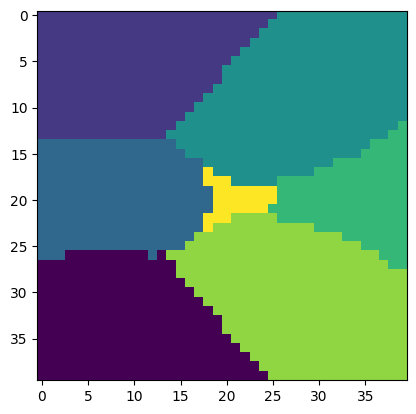

In [38]:
clf = svm.SVC(kernel='precomputed')
with open(file_path_train_DMRG, "rb") as f:
    dataset = pickle.load(f)

with h5py.File(file_path_kernel_train_DMRG, "r") as f:
    kernel_train = f[" gram_train_DMRG_partial"][:] 

with h5py.File(file_path_kernel_test_DMRG, "r") as f:
    kernel_test = f["gram_test_partial"][:] 

y = dataset[1]
clf.fit(kernel_train, y) 
y_pred = clf.predict(kernel_test)
plt.imshow(y_pred.reshape(40,40))
plt.savefig(f'result for DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()